In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
sym = 'NQ'
start_date = '20190501'
end_date='20191231'
periods=[5,10,20,40,80,160]
roc_periods = [5,10,20,40]
s='20180501'
params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s),
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s),
    'carver': calibrate_multiple(sym, carver, start_date=s),
    'roc': calibrate_multiple(sym, roc, start_date=s, periods=roc_periods),
    'roca': calibrate_multiple(sym, roca, start_date=s),
}

inds = {
    #'bolli_reduced': simulate(params['bolli_reduced'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
    #'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=periods),
    'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=roc_periods),
    #'roca': simulate(params['roca'], sym, roca, start_date=start_date, end_date=end_date, periods=periods),
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}


In [11]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
ema,9.15674,5.58651
breakout,8.81039,6.19345
roc,9.57939,6.34808


In [12]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,ema,breakout,roc
ema,1.000000,0.747466,0.699454
breakout,0.747466,1.000000,0.845059
roc,0.699454,0.845059,1.000000


In [13]:
c.sum()

ema         2.446920
breakout    2.592524
roc         2.544513
dtype: float64

In [14]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()}).dropna()
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df.dropna()

In [15]:
data=combine(inds,)

In [16]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.499506223529231, 5.4537242214994475)

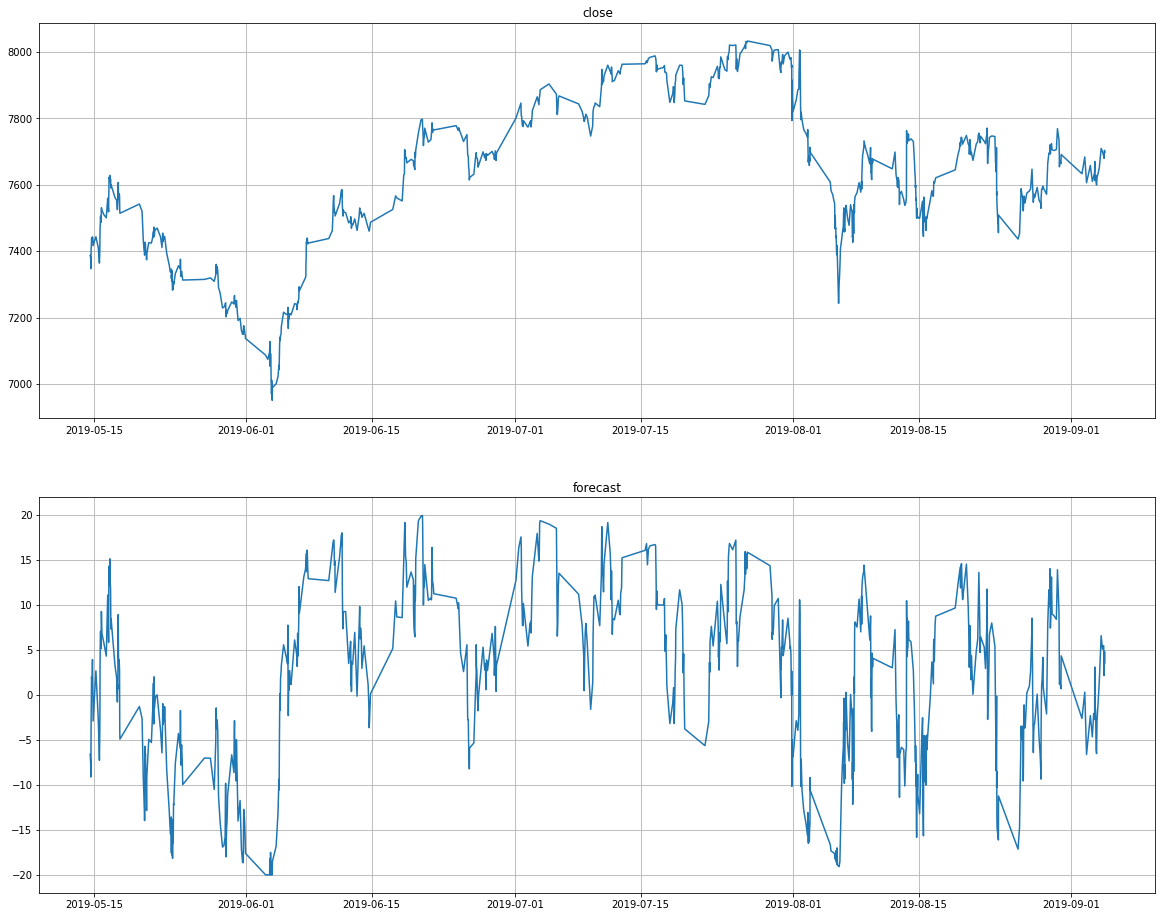

In [17]:
plot(data[['close', 'forecast']])

In [18]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.042384,-0.0342401,-0.080346,-0.0281429,-0.0561953,-0.0286478,0.0240749,0.0346235,-0.0420129
Cumulative returns,0.013766,-0.0114095,-0.0272098,-0.00935815,-0.0188689,-0.00952768,0.00786627,0.0112739,-0.0140372
Annual volatility,0.189172,0.162964,0.163588,0.158231,0.156793,0.121965,0.0818715,0.068517,0.0280742
Sharpe ratio,0.312817,-0.133601,-0.43148,-0.102651,-0.291768,-0.178507,0.330659,0.53024,-1.51474
Calmar ratio,0.523041,-0.3089,-0.85604,-0.415586,-0.822673,-0.458081,1.04676,1.25808,-2.47567
Stability,0.422358,0.209107,0.0583717,0.141917,2.25617e-06,0.00192842,0.158068,0.136544,0.473544
Max drawdown,-0.0810339,-0.110845,-0.0938578,-0.0677186,-0.0683082,-0.0625386,-0.0229994,-0.0275208,-0.0169704
Omega ratio,1.05348,0.978111,0.928748,0.981745,0.947146,0.961538,1.1115,1.24447,0.380212
Sortino ratio,0.458161,-0.207282,-0.663005,-0.163171,-0.456135,-0.296014,0.637528,1.29019,-1.57787
Skew,0.10633,0.638038,0.739975,0.847904,0.844074,1.5492,2.718,4.3198,-6.47375


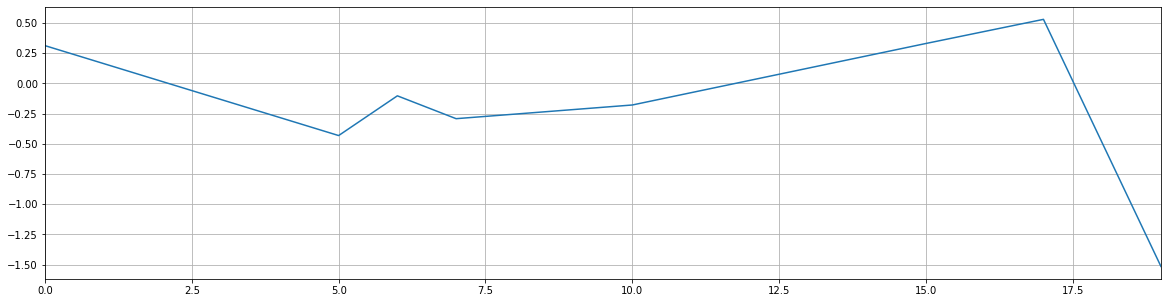

In [19]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [20]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.853528,0.784092,0.792567,0.744167,0.666989,0.446960,0.390468,0.215119
3,0.853528,1.000000,0.935732,0.873028,0.839332,0.742224,0.528608,0.453919,0.301381
5,0.784092,0.935732,1.000000,0.943065,0.906715,0.800750,0.585036,0.486737,0.251195
6,0.792567,0.873028,0.943065,1.000000,0.969729,0.859116,0.635178,0.501710,0.195931
7,0.744167,0.839332,0.906715,0.969729,1.000000,0.887797,0.659383,0.508931,0.189296
10,0.666989,0.742224,0.800750,0.859116,0.887797,1.000000,0.801598,0.625731,0.161057
15,0.446960,0.528608,0.585036,0.635178,0.659383,0.801598,1.000000,0.840486,0.161112
17,0.390468,0.453919,0.486737,0.501710,0.508931,0.625731,0.840486,1.000000,0.082149
19,0.215119,0.301381,0.251195,0.195931,0.189296,0.161057,0.161112,0.082149,1.000000


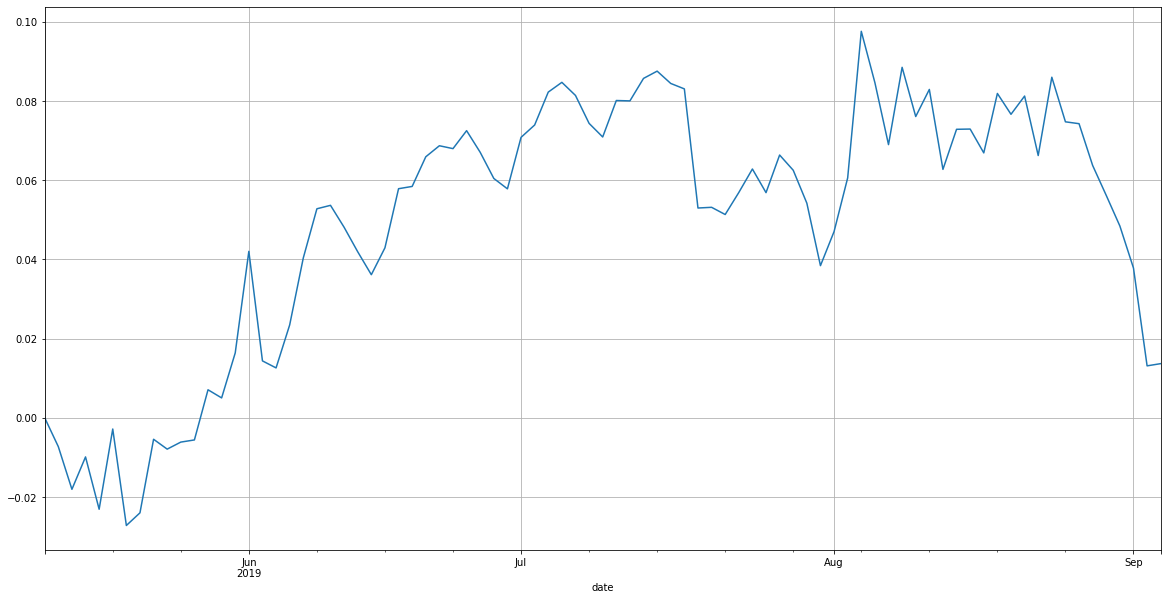

In [21]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

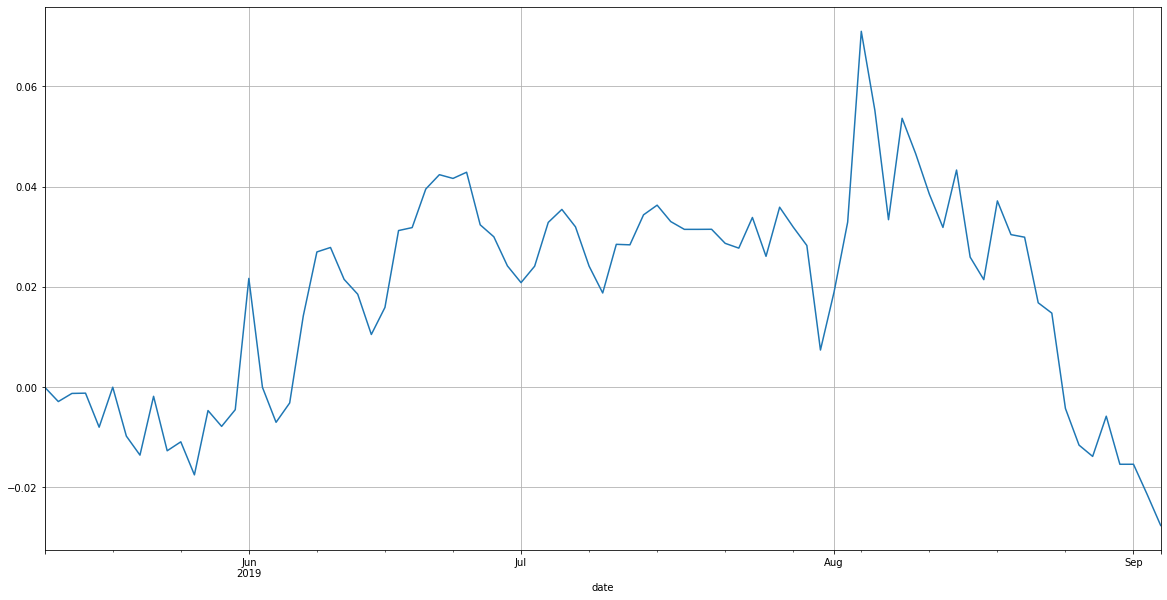

In [22]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

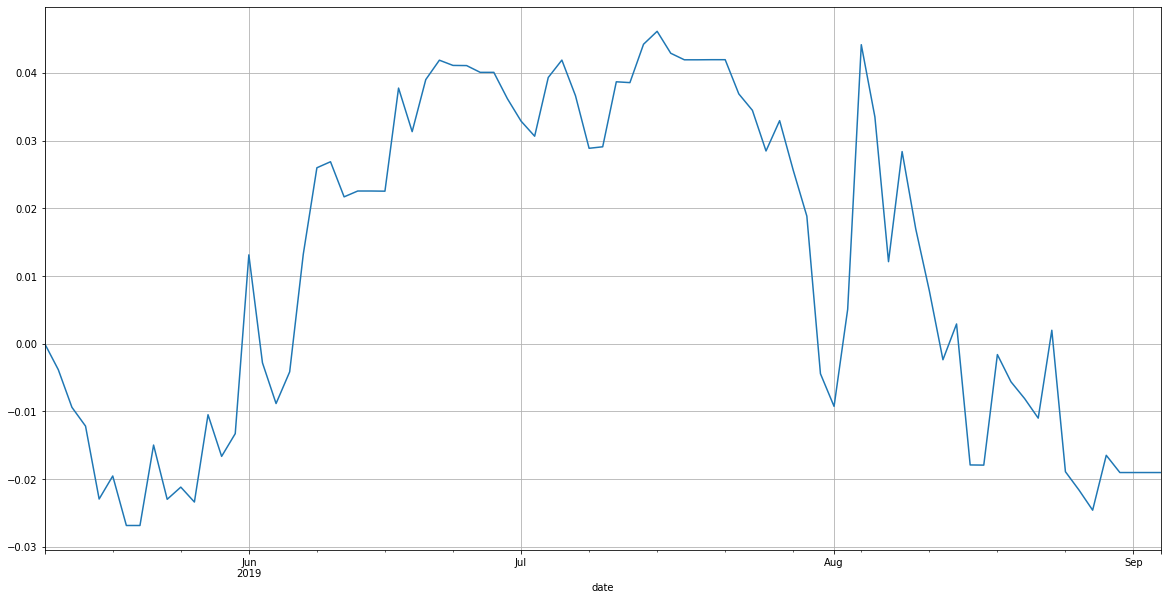

In [23]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

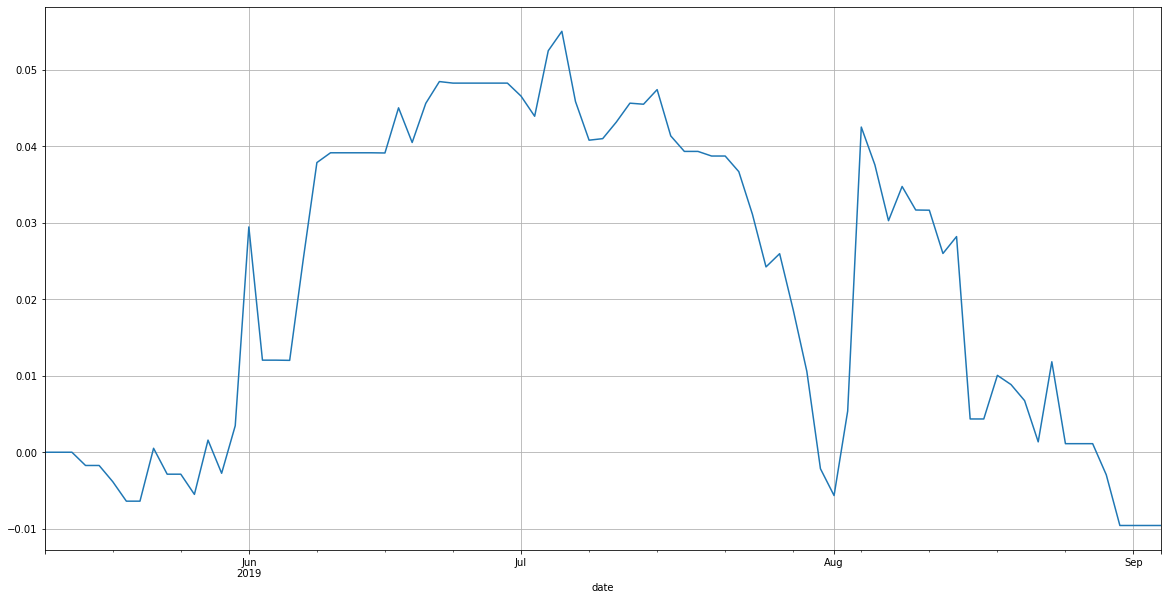

In [24]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);